In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [2]:
df=pd.read_csv('Books.csv')
df.head()

<ipython-input-2-1890c987b6ec>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
mv = df.isnull()
mv.count()

,0
ISBN,271360
Book-Title,271360
Book-Author,271360
Year-Of-Publication,271360
Publisher,271360
Image-URL-S,271360
Image-URL-M,271360
Image-URL-L,271360


In [4]:
df.dropna()
df.drop_duplicates(inplace=True)
df_cleaned = df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])
df_cleaned = df_cleaned.drop_duplicates(subset='Book-Title', keep='first')
print(df_cleaned.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')


In [5]:
print(df_cleaned.describe())

              ISBN                                         Book-Title  \
count       242135                                             242135   
unique      242135                                             242135   
top     0767409752  A Guided Tour of Rene Descartes' Meditations o...   
freq             1                                                  1   

                Book-Author  Year-Of-Publication  Publisher  
count                242133               242135     242134  
unique                99684                  192      16461  
top     William Shakespeare                 2002  Harlequin  
freq                    491                12507       7414  


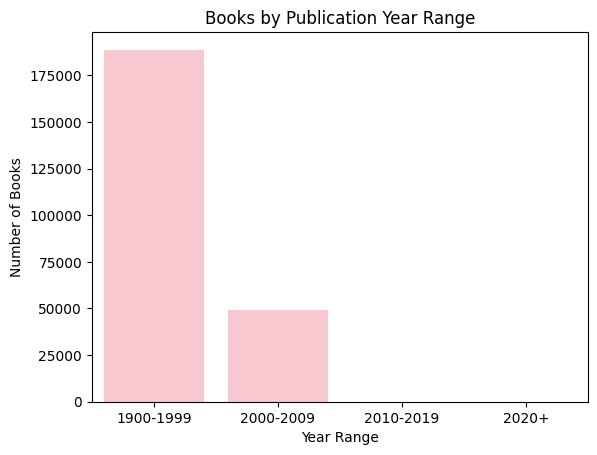

In [6]:
df_cleaned['Year-Of-Publication'] = pd.to_numeric(df_cleaned['Year-Of-Publication'], errors='coerce')
bins = [1900, 2000, 2010, 2020, 2030]
labels = ['1900-1999', '2000-2009', '2010-2019', '2020+']
df_cleaned['Year-Range'] = pd.cut(df_cleaned['Year-Of-Publication'], bins=bins, labels=labels)

sns.countplot(x='Year-Range', data=df_cleaned, color='pink')
plt.title("Books by Publication Year Range")
plt.xlabel("Year Range")
plt.ylabel("Number of Books")
plt.show()

<ipython-input-7-3dfbd6664a66>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.values, y=author_counts.index, palette='pastel')


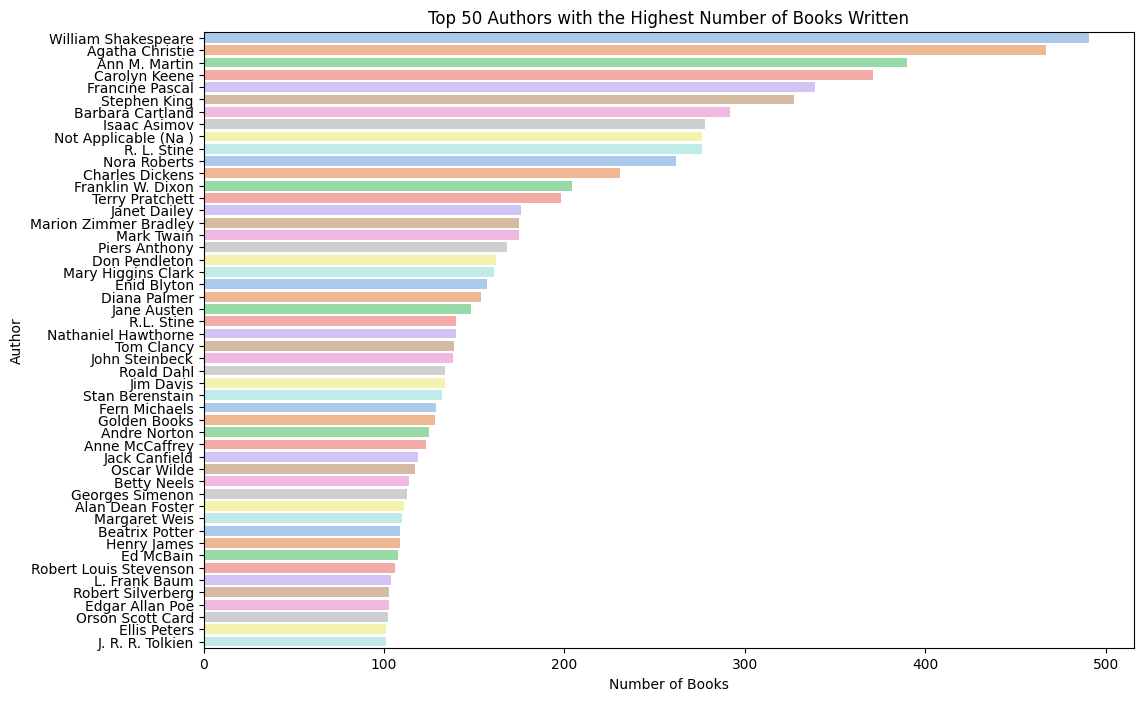

In [7]:
author_counts = df_cleaned['Book-Author'].value_counts().head(50)
plt.figure(figsize=(12, 8))
sns.barplot(x=author_counts.values, y=author_counts.index, palette='pastel')
plt.title("Top 50 Authors with the Highest Number of Books Written")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['Book-Title'])

words = tfidf_vectorizer.get_feature_names_out()
svd = TruncatedSVD(n_components=2, random_state=42)
svd.fit(tfidf_matrix)
components = svd.components_

top_n = 10

for i, component in enumerate(components):

    top_indices = component.argsort()[-top_n:][::-1]

    top_words = [words[idx] for idx in top_indices]

    print(f"Component {i + 1}:")
    print(", ".join(top_words))
    print()

Component 1:
novel, book, love, life, world, harlequin, man, series, amp, romance

Component 2:
book, love, little, harlequin, romance, stories, series, life, world, guide



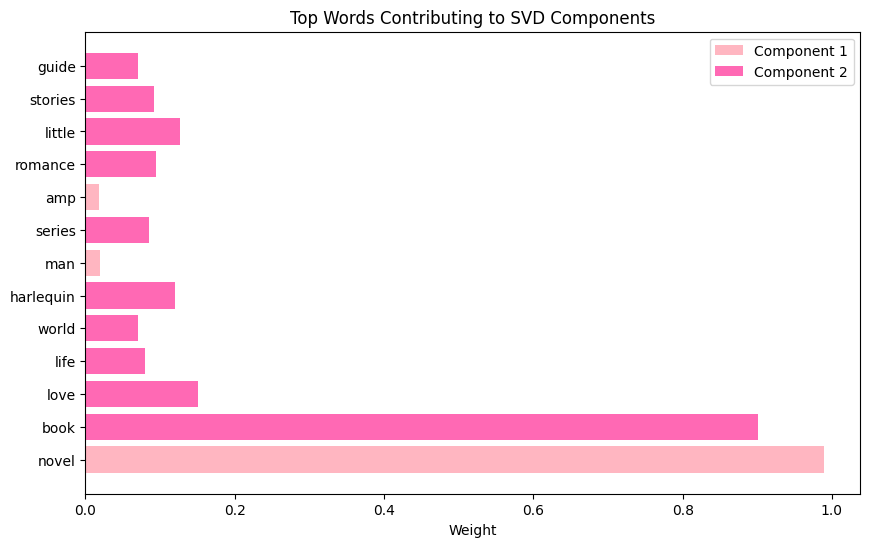

In [9]:
plt.figure(figsize=(10, 6))
colors = ['#FFB6C1', '#FF69B4', '#FF1493', '#C71585', '#DB7093']

for i, component in enumerate(components):
    top_indices = component.argsort()[-top_n:][::-1]
    top_words = [words[idx] for idx in top_indices]

    plt.barh(top_words, component[top_indices], label=f"Component {i + 1}", color=colors[i])

plt.xlabel('Weight')
plt.title('Top Words Contributing to SVD Components')
plt.legend()
plt.show()

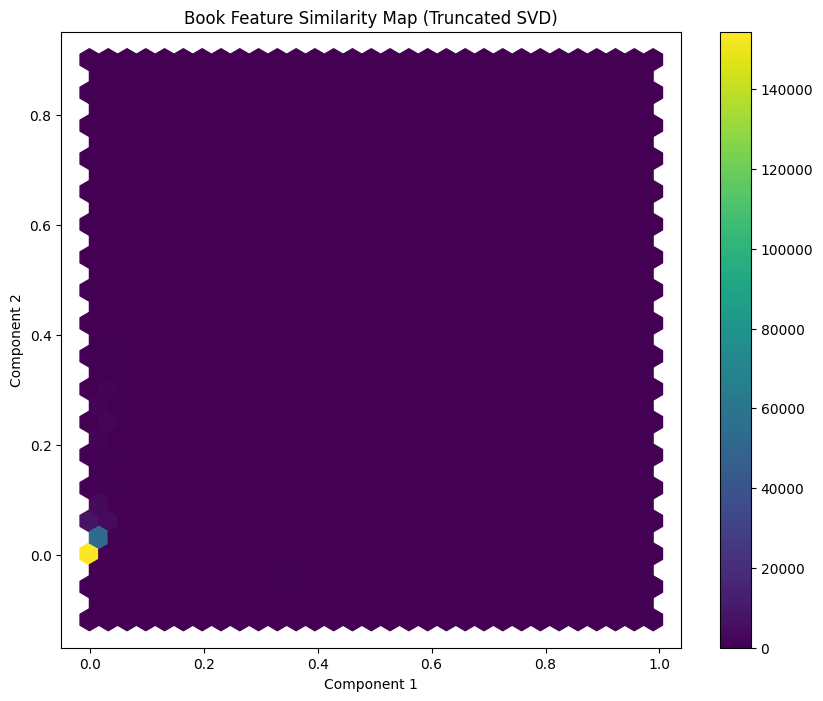

In [10]:
svd = TruncatedSVD(n_components=2, random_state=42)
reduced = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
plt.hexbin(reduced[:, 0], reduced[:, 1], gridsize=30)
plt.colorbar()
plt.title('Book Feature Similarity Map (Truncated SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [20]:
def get_book_similarity(book_title, tfidf_matrix, tfidf_vectorizer, df_cleaned):
    idx = df_cleaned[df_cleaned['Book-Title'] == book_title].index[0]

    book_vector = tfidf_matrix[idx]

    cosine_sim = cosine_similarity(book_vector, tfidf_matrix)

    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]

    return df_cleaned['Book-Title'].iloc[book_indices]

recommended_books = get_book_similarity('Harry Potter and the Chamber of Secrets (Book 2)', tfidf_matrix, tfidf_vectorizer, df_cleaned)
print(recommended_books)

195507    Eisenhower's Lieutenants: The Campaign of Fran...
207302    Antietam Campaign: August-September 1862 (Grea...
16600                                                August
42812                                     The Polish August
248320                                      Not This August
256849                                     Forgiving August
174375                                The Buchanan Campaign
258981                                  Georgina's Campaign
38275                                                France
42779                                       Floyd on France
Name: Book-Title, dtype: object
